In [ ]:
# pip install clickhouse_driver

In [4]:
import requests
import pandas as pd
import time
import json
import matplotlib.pyplot as plt

from tqdm import tqdm
from clickhouse_driver import Client

# Сбор данных по участникам группы

**Получение user_id_vk, fullname, last_seen, contacts, friends_count, town**

*1. Выгрузить участников группы (https://vk.com/vk_fishing), в формате (user_id_vk, fullname, last_seen, contacts, friends_count, town)*


Первым этапом получим поля user_id_vk, first_name, last_name, last_seen, contacts, town, а так же bdate (т.к. далее требуется построить диаграмму рассеяния, в которой требуется возраст).

In [4]:
FIELDS = "bdate,last_seen,contacts,city" 
METHOD_GROUP_MEMBERS = "groups.getMembers"
GROUPID = "vk_fishing"
TOKEN = "*****"

In [15]:
# Узнаем общее кол-во необходимых запросов, зная, что один запрос возвращает 1000 записей
req = requests.get(f"https://api.vk.com/method/{METHOD_GROUP_MEMBERS}?group_id={GROUPID}&fields={FIELDS}&access_token={TOKEN}&v=5.199 HTTP/1.1").json()
NUM_PAGES = int(req["response"]["count"] / 1000) 

In [ ]:
# Базовый сбор данных, получаем все поля кроме friends_count
res = []
for i in tqdm(range(NUM_PAGES+1)): 
    pagination = i * 1000
    try:
        req = requests.get(f"https://api.vk.com/method/{METHOD_GROUP_MEMBERS}?group_id={GROUPID}&offset={pagination}&fields={FIELDS}&access_token={TOKEN}&v=5.199 HTTP/1.1").json()
        if "response" in req:
            res.extend(req["response"]["items"])
            if i % 50 == 0:
                print(req["response"]["items"][1])  # Проверка каждой 1й записи каждой 50й страницы, что не получили капчу или ограничения
        else:
            raise ValueError(f"{req}")
    except Exception as e:
        print(f"An error occurred: {e}")
    time.sleep(0.35)

In [19]:
with open('raw_group_members.json', 'w') as f:
    json.dump(res, f)

In [ ]:
with open('raw_group_members.json', 'r') as f:
    df_raw_json = json.load(f)

In [ ]:
df_without_friends = pd.json_normalize(df_raw_json)  

**Загрузка данных по друзьям**

In [ ]:
# Список для хранения результатов
results = []  

In [336]:
# Список id пользователей
user_id = df_without_friends['id'].tolist() 
user_id.sort()

**1й метод - friends.get**

Этим методом получается отправлять в день около 5000 запросов, даже через метод execute, затем идет блокировка на день. В сумме им получилось достать данные по 10999 пользователям.

In [403]:
# Перебираем список ID и отправляем запросы по 25 ID за раз c помощью метода execute и VKScript
def get_friends(user_ids):
    """
    Функция отправляет запросы к API VK, чтобы получить количество друзей
    для каждого пользователя в списке user_ids. Запросы отправляются пакетами
    по 25 пользователей с задержкой между запросами для предотвращения
    превышения лимита запросов.

    Параметры:
    user_ids (list): Список идентификаторов пользователей.

    Обработка ошибок:
    - Если ошибка связана с достижением лимита запросов (error_code == 29), выполнение цикла прекращается.
    - Все другие исключения обрабатываются в блоке except.
    """
    try:
        for i in tqdm(range(0, len(user_ids), 25)):
            time.sleep(0.35)
            batch = user_ids[i:i + 25]
            code = """
            var users = %s;
            var result = [];
            var i = 0;
            while (i < users.length) {
                var friends = API.friends.get({"user_id": users[i]});
                if (friends) {
                    result.push({"user_id": users[i], "friends_count": friends.count});
                }
                i = i + 1;
            }
            return result;
            """ % json.dumps(batch)
            
            response = requests.post(
                'https://api.vk.com/method/execute',
                data={
                    'code': code,
                    'access_token': TOKEN,
                    'v': 5.199
                }
            ).json()
        
            if 'response' in response:
                results.extend(response['response'])
            elif 'error' in response:
                error_code = response['error']['error_code']
                print(f"Error for batch starting with ID {batch[0]}: {response['error']}")
                if error_code == 29:
                    print("Rate limit reached. Stopping the execution.")
                    break
    except Exception as e:
        print(f"An unexpected error occurred: {e}")                  

In [ ]:
get_friends(user_id)

In [393]:
with open('friends.json', 'w') as f:
    json.dump(results, f)

**2й метод - users.get**

У этого метода нет суточных ограничений, но он довольно медленный. Им получилось скачать данные по 80000 за ночь через execute. Я его запускала в другом ноутбуке, поэтому здесь только пример функции и готовый результат скачивания. 

In [ ]:
# def get_friends(user_ids):
#     try:
#         for i in tqdm(range(0, 3)):
#             time.sleep(0.35)
#             batch = user_ids[i:i + 25]
#             code = """
#             var users = %s;
#             var result = [];
#             var i = 0;
#             while (i < users.length) {
#                 var user_info = API.users.get({
#                     "user_ids": users[i],
#                     "fields": "counters"
#                 })[0];
#                 if (user_info) {
#                     var friends_count = user_info.counters ? user_info.counters.friends : null;
#                     result.push({"user_id": users[i], "friends_count": friends_count});
#                 }
#                 i = i + 1;
#             }
#             return result;
#             """ % json.dumps(batch)
            
#             response = requests.post(
#                 'https://api.vk.com/method/execute',
#                 data={
#                     'code': code,
#                     'access_token': TOKEN,
#                     'v': 5.199
#                 }
#             ).json()
        
#             if 'response' in response:
#                 results.extend(response['response'])
#             elif 'error' in response:
#                 error_code = response['error']['error_code']
#                 print(f"Error for batch starting with ID {batch[0]}: {response['error']}")
#                 if error_code == 29:
#                     print("Rate limit reached. Stopping the execution.")
#                     break
#     except Exception as e:
#         print(f"An unexpected error occurred: {e}")  

In [161]:
with open('friends_2.json', 'r') as f:
    friends_2 = json.load(f)

In [163]:
with open('friends.json', 'r') as f:
    friends_1 = json.load(f)

Объединим списки

In [165]:
friends_data = friends_1 + friends_2

**Объединение данных**

In [168]:
 # Переводим данные в табличный вид
df_friends = pd.DataFrame(friends_data)

In [169]:
df_friends = df_friends.drop_duplicates()

In [170]:
df = pd.merge(df_without_friends, df_friends, left_on='id', right_on='user_id', how='left')

# Обработка данных

In [172]:
# Оставляем только нужные столбцы
df = df[["id", "first_name", "last_name", "city.title", "last_seen.time", "bdate", "mobile_phone", "home_phone", "friends_count"]]

# Переименовываем
df = df.rename({'id': 'user_id_vk', 'city.title': 'town', 'last_seen.time': 'last_seen'}, axis=1)

# Столбцы mobile_phone и home_phone заменяем на один столбец contacts
df['contacts'] = df['mobile_phone'].combine_first(df['home_phone'])
df = df.drop(['mobile_phone', 'home_phone'], axis=1)

df = df[['user_id_vk', 'first_name', 'last_name', 'last_seen', 'contacts', 'friends_count', 'town', 'bdate']]

In [174]:
# Поменяем типы данных на более подходящие
# в Clickhouse невозможно загрузить типы данных такие как NaN, pd.NA, NaT, поэтому на данном этапе придумала только загрузку в виде строк.

df['last_seen'] = df['last_seen'].apply(lambda x: None if pd.isna(x) else str(x))
df['last_seen'] = df['last_seen'].apply(lambda x: None if pd.isna(x) else (x[:(len(x)-2)]))

df['contacts'] = df['contacts'].apply(lambda x: None if pd.isna(x) else str(x))

df['town'] = df['town'].apply(lambda x: None if pd.isna(x) else str(x))

df['bdate'] = df['bdate'].apply(lambda x: None if pd.isna(x) else str(x))

df['friends_count'] = df['friends_count'].apply(lambda x: None if pd.isna(x) else str(x))
df['friends_count'] = df['friends_count'].apply(lambda x: None if pd.isna(x) else (x[:(len(x)-2)]))

data = df.values.tolist()

In [175]:
# Финальный набор данных
df.to_csv("vk_group_members", index=False)

In [176]:
df.head(3)

,user_id_vk,first_name,last_name,last_seen,contacts,friends_count,town,bdate
0,48,Миша,Мельников,None,None,None,Москва,None
1,1018,Ярик,Бурим,1613708136,None,100,Санкт-Петербург,None
2,1185,Алексей,Могилов,None,None,None,Новомосковск,17.9


# Загрузка данных в Clickhouse

In [177]:
# Подключение к ClickHouse
client = Client(host='localhost', port=9000, user='****', password='****', database='****')

In [178]:
client.execute('DROP TABLE IF EXISTS group_members')

client.execute('''
CREATE TABLE IF NOT EXISTS group_members (
    user_id_vk UInt32,
    first_name Nullable(String), 
    last_name Nullable(String),
    town Nullable(String),
    contacts Nullable(String),  
    last_seen Nullable(String),
    friends_count Nullable(String),
    bdate Nullable(String)
) ENGINE = MergeTree()
ORDER BY user_id_vk
''')

[]

In [179]:
# Вставка данных в таблицу vk_users
data_users = df[['user_id_vk', 'first_name', 'last_name', 'town', 'contacts', 'last_seen', 'friends_count', 'bdate']].values.tolist()
client.execute('INSERT INTO group_members VALUES', data_users, types_check=True)

858333

# Визуализация данных

3. Используя Python и SQL, создать графики:
- Топ - 5 самых популярных имен
- Диаграммы рассеяния - Сколько лет (Кол-во друзей)
  
Дать ответы на следующие вопросы:
- Выдать топ-3 города, в которых среднее кол-во друзей участников группы самое наибольшее
- Какой город самый часто встречаемый у участников этой группы


#### Топ - 5 самых популярных имен

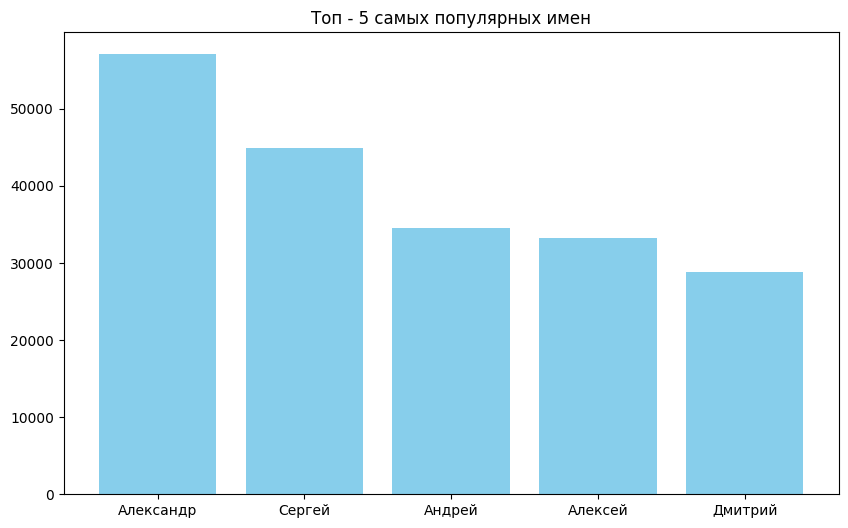

In [180]:
query_top_names = """
SELECT first_name, 
       COUNT(*) as popular_names
FROM group_members
GROUP BY first_name
ORDER BY popular_names DESC
LIMIT 5;
"""
result = client.execute(query_top_names)

df_top_names = pd.DataFrame(result, columns=['name', 'count'])

plt.figure(figsize=(10, 6))
plt.bar(df_top_names['name'], df_top_names['count'], color='skyblue')
plt.title('Топ - 5 самых популярных имен')
plt.show()

#### Диаграммы рассеяния - Сколько лет (Кол-во друзей)

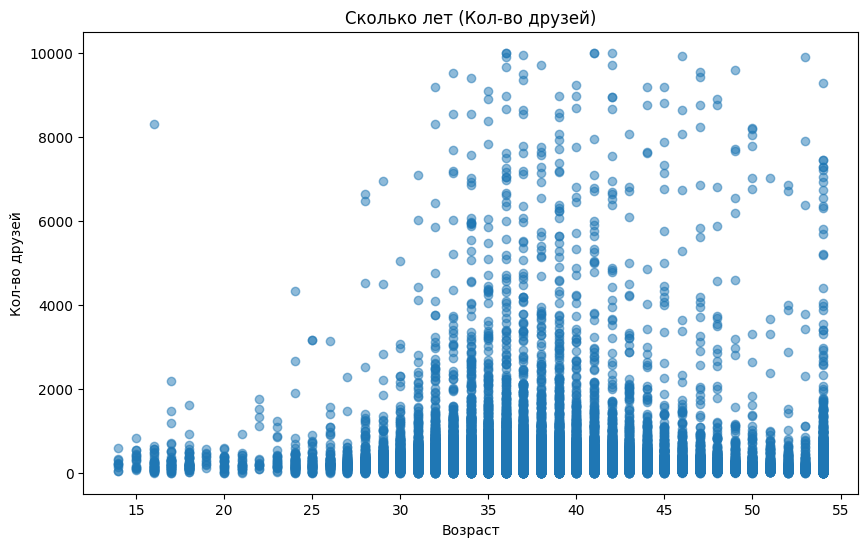

In [181]:
query_num_friends = """
SELECT
    CASE
        WHEN length(bdate) - length(replaceAll(bdate, '.', '')) = 2 THEN dateDiff('year', toDate(parseDateTimeBestEffortOrNull(bdate)), today())
        ELSE NULL
    END AS age,
    toInt32(friends_count) friends_int
FROM group_members
WHERE age IS NOT NULL AND friends_int IS NOT NULL;
"""
result = client.execute(query_num_friends)
df_num_friends = pd.DataFrame(result, columns=['age', 'friends_int'])

plt.figure(figsize=(10, 6))
plt.scatter(df_num_friends['age'], df_num_friends['friends_int'], alpha=0.5)
plt.xlabel('Возраст')
plt.ylabel('Кол-во друзей')
plt.title('Сколько лет (Кол-во друзей)')
plt.show()

#### Выдать топ-3 города, в которых среднее кол-во друзей участников группы самое наибольшее

In [182]:
query_top_town_friends = """
SELECT
    town,
    AVG(toInt32(friends_count)) average_friends
FROM group_members
WHERE town IS NOT NULL
GROUP BY town
ORDER BY average_friends DESC
LIMIT 3;
"""
result = client.execute(query_top_town_friends)
df_top_town_friends = pd.DataFrame(result, columns=['city', 'count'])

print(df_top_town_friends)

                 city   count
0  Западное Кончезеро  9712.0
1          Судромская  9282.0
2            Ko Samui  8899.0


#### Какой город самый часто встречаемый у участников этой группы

In [183]:
query_popular_town = """
SELECT town, 
       COUNT(*) as count
FROM group_members
WHERE town IS NOT NULL
GROUP BY town
ORDER BY count DESC
LIMIT 1;
"""
result = client.execute(query_popular_town)
df_popular_town = pd.DataFrame(result, columns=['city', 'count'])

print(df_popular_town)

     city  count
0  Москва  45388
